In [1]:
import pandas as pd
import networkx as nx
from pathlib import Path
import matplotlib.pyplot as plt
import os
import uuid
import copy
import shutil

# Load the Excel file
WORKBOOK_PATH_OLD = Path('../../data/assemblies.xlsx')
WORKBOOK_PATH = Path('../../data/assemblies_22_update.xlsx')
df = pd.read_excel(WORKBOOK_PATH, sheet_name=0)
for col in ['PredecessorIDs', 'SuccessorIDs']:
    df[col] = df.get(col, '').fillna('').astype(str)

# Validate input data
valid_task_ids = set(df['ID'].astype(int))
for _, row in df.iterrows():
    task_id = int(row['ID'])
    pred_str = row['PredecessorIDs'].strip()
    succ_str = row['SuccessorIDs'].strip()
    if pred_str:
        try:
            pred_ids = [int(x) for x in pred_str.split(',') if x.strip()]
            for pred_id in pred_ids:
                if pred_id not in valid_task_ids:
                    raise ValueError(f"Invalid PredecessorID {pred_id} for task {task_id}")
        except ValueError as e:
            raise ValueError(f"Invalid PredecessorIDs for task {task_id}: {pred_str} ({str(e)})")
    if succ_str:
        try:
            succ_ids = [int(x) for x in succ_str.split(',') if x.strip()]
            for succ_id in succ_ids:
                if succ_id not in valid_task_ids:
                    raise ValueError(f"Invalid SuccessorID {succ_id} for task {task_id}")
        except ValueError as e:
            raise ValueError(f"Invalid SuccessorIDs for task {task_id}: {succ_str} ({str(e)})")
    if row.get('EdgeWeight', 0) < 0:
        raise ValueError(f"Negative EdgeWeight for task {task_id}: {row['EdgeWeight']}")
    if row.get('PartnerWeight', 0) < 0:
        raise ValueError(f"Negative PartnerWeight for task {task_id}: {row['PartnerWeight']}")

# Initialize the DAG
G = nx.DiGraph()

# Add source and sink nodes
source_id = int(df['ID'].min()) - 1
sink_id = int(df['ID'].max()) + 1
if source_id in df['ID'].values or sink_id in df['ID'].values:
    raise ValueError(f"Source ID {source_id} or Sink ID {sink_id} conflicts with existing task IDs")
G.add_node(source_id, duration=0, description='Source')
G.add_node(sink_id, duration=0, description='Sink')

# Step 1: Add task and partner nodes
partner_nodes = set()
task_nodes = set()
for _, row in df.iterrows():
    task_id = int(row['ID'])
    partner = row.get('Partners', '').strip()
    partner_weight = row.get('PartnerWeight', 0)
    edge_weight = row.get('EdgeWeight', 0)
    description = row.get('Description', '')
    
    # Add task node
    G.add_node(
        task_id,
        duration=edge_weight,
        description=description
    )
    task_nodes.add(task_id)
    
    # Add partner node if PartnerWeight is non-zero and partner exists
    if partner_weight > 0 and partner:
        partner_node_id = f"{partner}-{task_id}"
        partner_nodes.add(partner_node_id)
        G.add_node(
            partner_node_id,
            duration=partner_weight,
            description=f"{partner} for {task_id}"
        )
        # Connect source to partner node
        G.add_edge(source_id, partner_node_id, weight=0)
        # Connect partner node to its task node
        G.add_edge(partner_node_id, task_id, weight=partner_weight)

# Step 2: Add predecessor edges
for _, row in df.iterrows():
    task_id = int(row['ID'])
    pred_str = row['PredecessorIDs'].strip()
    if pred_str:
        for pred_id in [int(x) for x in pred_str.split(',') if x.strip()]:
            pred_edge_weight = df[df['ID'] == pred_id]['EdgeWeight'].iloc[0]
            if not G.has_edge(pred_id, task_id):
                G.add_edge(pred_id, task_id, weight=pred_edge_weight)

# Step 3: Add successor edges
for _, row in df.iterrows():
    task_id = int(row['ID'])
    succ_str = row['SuccessorIDs'].strip()
    if succ_str:
        for succ_id in [int(x) for x in succ_str.split(',') if x.strip()]:
            # Always connect to the successor's task node (integer ID)
            target_node = succ_id
            edge_weight = row['EdgeWeight']
            if not G.has_edge(task_id, target_node):
                G.add_edge(task_id, target_node, weight=edge_weight)

# Step 4: Connect task nodes with no predecessors to source
for node in task_nodes:
    if G.in_degree(node) == 0:
        G.add_edge(source_id, node, weight=0)

# Step 5: Connect nodes with no successors to sink
for node in list(G.nodes()):
    if node in {source_id, sink_id}:
        continue
    if G.out_degree(node) == 0:
        G.add_edge(node, sink_id, weight=G.nodes[node]['duration'])


In [2]:
# Perform topological sort
try:
    topo_order = list(nx.topological_sort(G))
except nx.NetworkXUnfeasible:
    raise ValueError("Graph contains a cycle, cannot perform topological sort")

# Forward pass: Compute ES and EF
ES = {}
EF = {}
for node in topo_order:
    dur = G.nodes[node]['duration']
    preds = list(G.predecessors(node))
    ES[node] = 0 if not preds else max(EF[p] for p in preds)
    EF[node] = ES[node] + dur

# Backward pass: Compute LS and LF
LS = {}
LF = {}
project_end_time = EF[sink_id]
for node in reversed(topo_order):
    dur = G.nodes[node]['duration']
    succs = list(G.successors(node))
    LF[node] = project_end_time if not succs else min(LS[s] for s in succs)
    LS[node] = LF[node] - dur

# Create results DataFrame
results = []
for node in topo_order:
    slack = LS[node] - ES[node]
    results.append({
        'ID': node,
        'Description': G.nodes[node]['description'],
        'Duration': G.nodes[node]['duration'],
        'ES': ES[node],
        'EF': EF[node],
        'LS': LS[node],
        'LF': LF[node],
        'Slack': slack,
        'Critical': slack == 0
    })
res_df = pd.DataFrame(results)

# Create edge list DataFrame
edge_data = pd.DataFrame([
    {
        'Edge': f"{u}->{v}",
        'Description': f"{G.nodes[u]['description']}->{G.nodes[v]['description']}",
        'Weight': d['weight']
    }
    for u, v, d in G.edges(data=True)
])

In [3]:
# Find critical path
def find_critical_path(graph, source, sink, ES, LS):
    path = []
    current = sink
    while current != source:
        path.append(current)
        preds = list(graph.predecessors(current))
        if not preds:
            break
        current = max(preds, key=lambda p: EF[p] if LS[current] == EF[p] else -float('inf'))
    path.append(source)
    path.reverse()
    return path

# Find vertex-disjoint paths (task nodes only)
def find_vertex_disjoint_paths(graph, source, sink, task_nodes):
    # Create a flow network
    flow_G = nx.DiGraph()
    flow_G.add_node(source)
    flow_G.add_node(sink)
    for node in task_nodes:
        in_node = f"{node}_in"
        out_node = f"{node}_out"
        flow_G.add_node(in_node)
        flow_G.add_node(out_node)
        flow_G.add_edge(in_node, out_node, capacity=1)
    
    # Add edges from original graph (task nodes, source, sink)
    for u, v, data in graph.edges(data=True):
        if u == source and v in task_nodes:
            flow_G.add_edge(source, f"{v}_in", capacity=1)
        elif v == sink and u in task_nodes:
            flow_G.add_edge(f"{u}_out", sink, capacity=1)
        elif u in task_nodes and v in task_nodes:
            flow_G.add_edge(f"{u}_out", f"{v}_in", capacity=1)
    
    # Find vertex-disjoint paths
    paths = []
    while True:
        try:
            path = nx.shortest_path(flow_G, source, sink, method='dijkstra')
            original_path = []
            for node in path:
                if node == source or node == sink:
                    original_path.append(node)
                elif node.endswith('_in'):
                    original_node = int(node.replace('_in', ''))
                    if original_node in task_nodes:
                        original_path.append(original_node)
            for i in range(len(path) - 1):
                flow_G.remove_edge(path[i], path[i + 1])
            if len(original_path) > 2:  # Exclude trivial source->sink paths
                paths.append(original_path)
        except nx.NetworkXNoPath:
            break
    
    return paths

# Find all simple paths from source to sink
def find_all_paths(graph, source, sink, task_nodes):
    all_paths = []
    for path in nx.all_simple_paths(graph, source, sink):
        # Filter path to include only valid nodes (task nodes, source, sink)
        valid_path = [
            node for node in path
            if node in {source, sink} or (isinstance(node, int) and node in task_nodes)
        ]
        if len(valid_path) > 2:  # Ensure path has at least source, one task, sink
            all_paths.append(valid_path)
    return all_paths

# Compute critical path and disjoint paths
critical_path = find_critical_path(G, source_id, sink_id, ES, LS)
disjoint_paths = find_vertex_disjoint_paths(G, source_id, sink_id, task_nodes)
all_paths = find_all_paths(G, source_id, sink_id, task_nodes)

# Create path data for critical and disjoint paths
path_data = []
# Add critical path
if critical_path:
    task_desc = [
        f"{G.nodes[node]['description']} ({G.nodes[node]['duration']})"
        for node in critical_path
        if node not in {source_id, sink_id} and isinstance(node, int)
    ]
    total_duration = sum(G.nodes[node]['duration'] for node in critical_path if node not in {source_id, sink_id})
    path_data.append({
        'Path_ID': str(uuid.uuid4()),
        'Task_IDs': ','.join(str(node) for node in critical_path if node not in {source_id, sink_id} and isinstance(node, int)),
        'Descriptions': ' -> '.join(task_desc) if task_desc else 'No tasks',
        'Total_Duration': total_duration,
        'Is_Critical': True
    })

# Add disjoint paths
for path in disjoint_paths:
    if path == critical_path:
        continue
    task_desc = [
        f"{G.nodes[node]['description']} ({G.nodes[node]['duration']})"
        for node in path
        if node not in {source_id, sink_id} and isinstance(node, int)
    ]
    total_duration = sum(G.nodes[node]['duration'] for node in path if node not in {source_id, sink_id})
    path_data.append({
        'Path_ID': str(uuid.uuid4()),
        'Task_IDs': ','.join(str(node) for node in path if node not in {source_id, sink_id} and isinstance(node, int)),
        'Descriptions': ' -> '.join(task_desc) if task_desc else 'No tasks',
        'Total_Duration': total_duration,
        'Is_Critical': False
    })

# Create path DataFrame
paths_df = pd.DataFrame(path_data)

# Create all paths data
all_paths_data = []
for path in all_paths:
    task_desc = [
        f"{G.nodes[node]['description']} ({G.nodes[node]['duration']})"
        for node in path
        if node not in {source_id, sink_id} and isinstance(node, int)
    ]
    total_duration = sum(G.nodes[node]['duration'] for node in path if node not in {source_id, sink_id})
    is_critical = path == critical_path
    all_paths_data.append({
        'Path_ID': str(uuid.uuid4()),
        'Task_IDs': ','.join(str(node) for node in path if node not in {source_id, sink_id} and isinstance(node, int)),
        'Descriptions': ' -> '.join(task_desc) if task_desc else 'No tasks',
        'Total_Duration': total_duration,
        'Is_Critical': is_critical
    })

# Create all paths DataFrame
all_paths_df = pd.DataFrame(all_paths_data)

# Write to Excel
OUTPUT_PATH = f'timeline_v1_{str(uuid.uuid4())[:8]}.xlsx'
if os.path.exists(OUTPUT_PATH):
    os.remove(OUTPUT_PATH)
with pd.ExcelWriter(OUTPUT_PATH, engine='xlsxwriter') as writer:
    df.to_excel(writer, sheet_name='Raw_Tasks', index=False)
    edge_data.to_excel(writer, sheet_name='Edges', index=False)
    res_df.to_excel(writer, sheet_name='Scheduled_Results', index=False)
    paths_df.to_excel(writer, sheet_name='Critical_and_Disjoint_Paths', index=False)
    all_paths_df.to_excel(writer, sheet_name='All_Paths', index=False)

print(f"\nAll sheets written to {OUTPUT_PATH}")


All sheets written to timeline_v1_ea15dbec.xlsx


In [4]:
# Recreate output folder
gant_folder = 'gantt_charts'
if os.path.exists(gant_folder):
    shutil.rmtree(gant_folder)
os.makedirs(gant_folder, exist_ok=True)

# Function to create a Gantt chart for a path and save as PNG
def create_gantt_chart(path, res_df, task_nodes, source_id, sink_id, filename, bar_color='red', title='Gantt Chart'):
    # Filter path for task nodes only (exclude source, sink, partner nodes)
    task_nodes_in_path = [node for node in path if isinstance(node, int) and node not in {source_id, sink_id}]
    if len(task_nodes_in_path) < 2:
        print(f"Skipping {filename}: Path {path} has fewer than 2 task nodes ({len(task_nodes_in_path)})")
        return
    
    # Get ES and duration from res_df for task nodes
    tasks = res_df[res_df['ID'].isin(task_nodes_in_path)][['ID', 'Description', 'ES', 'Duration']]
    tasks = tasks.sort_values('ES')  # Sort by ES for consistent ordering
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, len(tasks) * 0.5 + 2))
    
    # Plot bars
    for idx, row in tasks.iterrows():
        ax.barh(
            y=f"{row['ID']}: {row['Description']}",
            width=row['Duration'],
            left=row['ES'],
            color=bar_color,
            edgecolor='black'
        )
    
    # Customize plot
    ax.set_xlabel('Time')
    ax.set_ylabel('Tasks')
    ax.set_title(title)
    ax.grid(True, which='both', linestyle='--', alpha=0.7)
    ax.invert_yaxis()
    plt.tight_layout()
    
    # Save in output folder and close
    filepath = os.path.join(gant_folder, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved Gantt chart as {filepath}")

In [5]:
# Collect all paths (critical + disjoint) and compute durations
path_durations = []
# Add critical path
if critical_path:
    task_nodes_in_critical = [node for node in critical_path if isinstance(node, int) and node not in {source_id, sink_id}]
    if len(task_nodes_in_critical) >= 2:
        total_duration = sum(G.nodes[node]['duration'] for node in critical_path if node not in {source_id, sink_id})
        path_durations.append((critical_path, total_duration, True))  # (path, duration, is_critical)

# Add disjoint paths
for path in disjoint_paths:
    if path == critical_path:
        continue  # Skip if already added
    task_nodes_in_path = [node for node in path if isinstance(node, int) and node not in {source_id, sink_id}]
    if len(task_nodes_in_path) >= 2:
        total_duration = sum(G.nodes[node]['duration'] for node in path if node not in {source_id, sink_id})
        path_durations.append((path, total_duration, False))  # (path, duration, is_critical)

# Sort by duration (descending) and select top 10
path_durations.sort(key=lambda x: x[1], reverse=True)
top_paths = path_durations[:10]

# Create Gantt charts for top 10 paths
for i, (path, duration, is_critical) in enumerate(top_paths, 1):
    bar_color = 'red' if is_critical else 'green'
    title = f'Critical Path Gantt Chart' if is_critical else f'Top Disjoint Path {i} Gantt Chart (Duration: {duration})'
    filename = f'critical_path_gantt.png' if is_critical else f'top_disjoint_path_{i}_gantt.png'
    create_gantt_chart(
        path, res_df, task_nodes, source_id, sink_id,
        filename=filename,
        bar_color=bar_color,
        title=title
    )

Saved Gantt chart as gantt_charts/critical_path_gantt.png
Saved Gantt chart as gantt_charts/top_disjoint_path_2_gantt.png
Saved Gantt chart as gantt_charts/top_disjoint_path_3_gantt.png
Saved Gantt chart as gantt_charts/top_disjoint_path_4_gantt.png
Saved Gantt chart as gantt_charts/top_disjoint_path_5_gantt.png
Saved Gantt chart as gantt_charts/top_disjoint_path_6_gantt.png
Saved Gantt chart as gantt_charts/top_disjoint_path_7_gantt.png
Saved Gantt chart as gantt_charts/top_disjoint_path_8_gantt.png
Saved Gantt chart as gantt_charts/top_disjoint_path_9_gantt.png
Saved Gantt chart as gantt_charts/top_disjoint_path_10_gantt.png


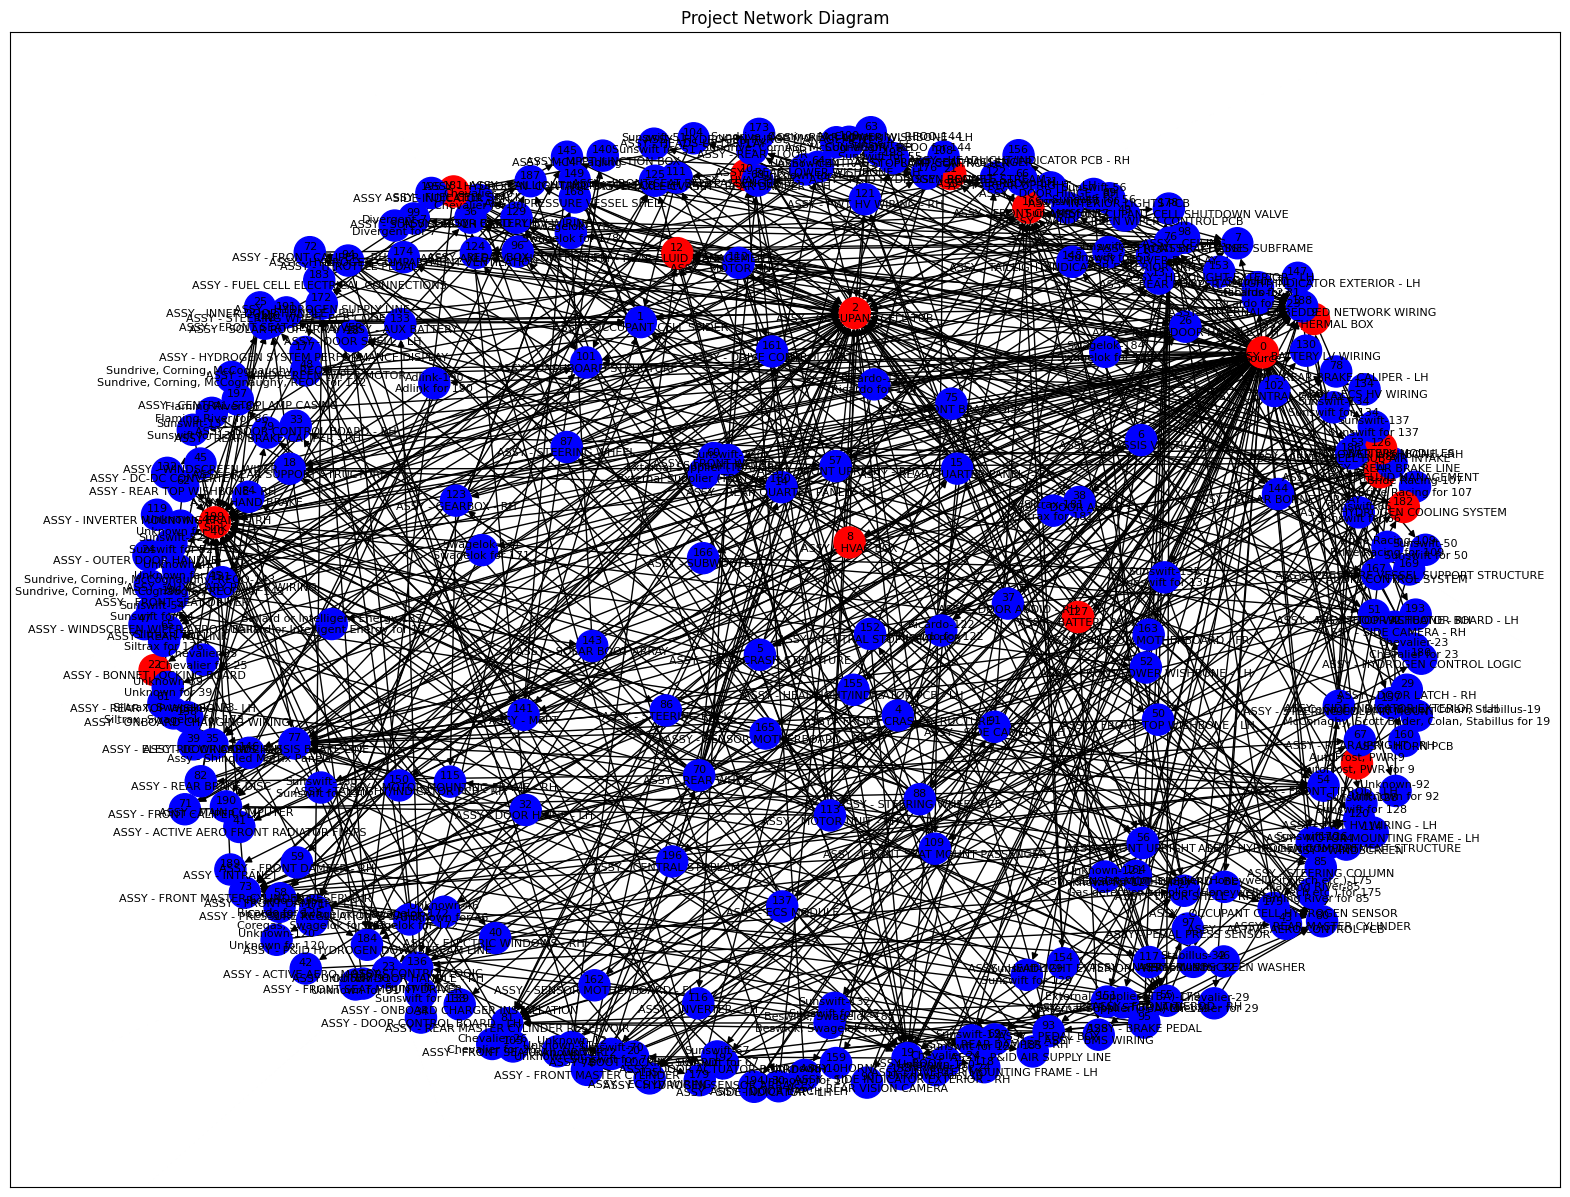

In [6]:
# Visualize network diagram
plt.figure(figsize=(20, 15))
pos = nx.spring_layout(G, k=1.5)
node_colors = ['blue'] * len(G.nodes())
for node in G.nodes():
    if node in res_df['ID'].values:
        if res_df[res_df['ID'] == node]['Slack'].values[0] == 0:
            node_colors[list(G.nodes()).index(node)] = 'red'
nx.draw_networkx(
    G,
    pos,
    with_labels=True,
    labels={node: f"{node}\n{G.nodes[node]['description']}" for node in G.nodes()},
    node_color=node_colors,
    node_size=500,
    font_size=8,
    arrows=True
)
plt.title('Project Network Diagram')
plt.savefig('network_diagram.png', dpi=300)
plt.show()